# MLiP13-Sjèl
## Coleridge Initiative - Show US the Data 
### Discover how data is used for the public good

### Notebooks we used: 
1. [Sentence-level analysis with Transformer](https://www.kaggle.com/poedator/sentence-level-analysis-with-transformer#Na%C3%AFve-Bayes-model)
2. [Coleridge Initiative-EDA & Baseline Model](https://www.kaggle.com/prashansdixit/coleridge-initiative-eda-baseline-model)



### Table of Content
* [1. Importing necessary modules and libraries](#1)
* [2. Data Exploration](#2)
* [3. Data Cleaning](#3)
* [4. Data Visualization](#4)
* [5. Baseline model and Submission](#5)
* [6. Sentence Classifier dataset creation](#6)
* [7. Naive Bayes classifier](#7)
* [8. Named Entity Recognition](#8)

<a id='1'></a>
# 1. Importing necessary modules and libraries

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import nltk
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 4000000
from nltk.probability import FreqDist
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, plot_confusion_matrix


from wordcloud import WordCloud, STOPWORDS
stopword_list = nltk.corpus.stopwords.words('english')

from tqdm.autonotebook import tqdm
import string

from fuzzywuzzy import fuzz

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline

os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')

['sample_submission.csv', 'train.csv', 'test', 'train']

We are provided with 4 main pieces of data:

* `train.csv:` The CSV file containing all the metadata of the publications, such as their title and the dataset they utilize.
* `train:` The directory containing the actual publications that are referenced in train.csv in JSON format.
* `test:` The directory containing the actual publications that will be used for testing purposes (thus, with no ground truth CSV file available).
* `sample_submission.csv:` The CSV file containing all the publications IDs in the test set, for which we'll have to populate the prediction column.

<a id='2'></a>
# 2. Data Exploration

In [2]:
# reading csv files and train & test file paths
train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
sample_sub = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'
sent_df = pd.read_csv('../input/sentencesdf2/sent_df2.csv') #dataset created from train_df with a per sentence label
nb_model = pickle.load(open('../input/nbmodel/nb_model.sav', 'rb'))

adnl_govt_labels_path = '../input/bigger-govt-dataset-list/data_set_800.csv'
adnl_govt_labels = pd.read_csv(adnl_govt_labels_path)

In [3]:
# train_df.head(6)

<a id='1'></a>
## 2.1 Data Description
train.csv - labels and metadata for the training set train/test directory - the full text of the training/test set's publications in JSON format, broken into sections with section titles

* `id` - publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets.
* `pub_title` - title of the publication (a small number of publications have the same title).
* `dataset_title` - the title of the dataset that is mentioned within the publication.
* `dataset_label` - a portion of the text that indicates the dataset.
* `cleaned_label` - the dataset_label, as passed through the clean_text function from the Evaluation page.

sample_submission.csv - a sample submission file in the correct format.
* `Id` - publication id.
* `PredictionString` - To be filled with equivalent of cleaned_label of train data.

In [4]:
# train_df.info()

Great! we don't have any null values.

In [5]:
# [print(f"{col}:{len(train_df[col].unique())}") for col in train_df.columns]   #finding unique values in each column

In [6]:
def read_append_return(filename, train_files_path=train_files_path, output='text'):
    """
    Function to read json file and then return the text data from them and append to the dataframe
    """
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [7]:
%%time
tqdm.pandas()   #tqdm is used to show any code running with a progress bar. 
train_df['text'] = train_df['Id'].progress_apply(read_append_return)

  0%|          | 0/19661 [00:00<?, ?it/s]

CPU times: user 11.4 s, sys: 4.35 s, total: 15.7 s
Wall time: 1min 41s


In [8]:
# train_df.head()

We have our text appended in our train dataframe.

In [9]:
%%time
tqdm.pandas()
sample_sub['text'] = sample_sub['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 40.9 ms, sys: 3.24 ms, total: 44.2 ms
Wall time: 72.5 ms


Also, we have the text of for the sample_submission file

In [10]:
# sample_sub.head()

<a id='3'></a>
# 3. Data Cleaning

Perform text cleaning for text processing. The text is cleaned as required for the final submission. 

In [11]:
def text_cleaning(text):
    '''
    Converts all text to lower case, Removes special charecters, emojis and multiple spaces
    text - Sentence that needs to be cleaned
    '''
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
#     text = re.sub("/'+/g", ' ', text)
    
    return text

In [12]:
%%time
tqdm.pandas()
train_df['cleaned_text'] = train_df['text'].progress_apply(text_cleaning)

  0%|          | 0/19661 [00:00<?, ?it/s]

CPU times: user 3min 44s, sys: 6.59 s, total: 3min 51s
Wall time: 3min 49s


In [13]:
# train_df.head()

In [14]:
%%time 
tqdm.pandas()
sample_sub['cleaned_text'] = sample_sub['text'].progress_apply(text_cleaning)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 106 ms, sys: 4.08 ms, total: 110 ms
Wall time: 110 ms


We have our data cleaned!

<a id='4'></a>
# 4. Data Visualization

In [15]:
words =list( train_df['cleaned_label'].values)
stopwords=['ourselves', 'hers','the','of','and','in', 'between', 'yourself', 'but', 'again','of', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

### 100 Most common words (cleaned_label) - WordCloud

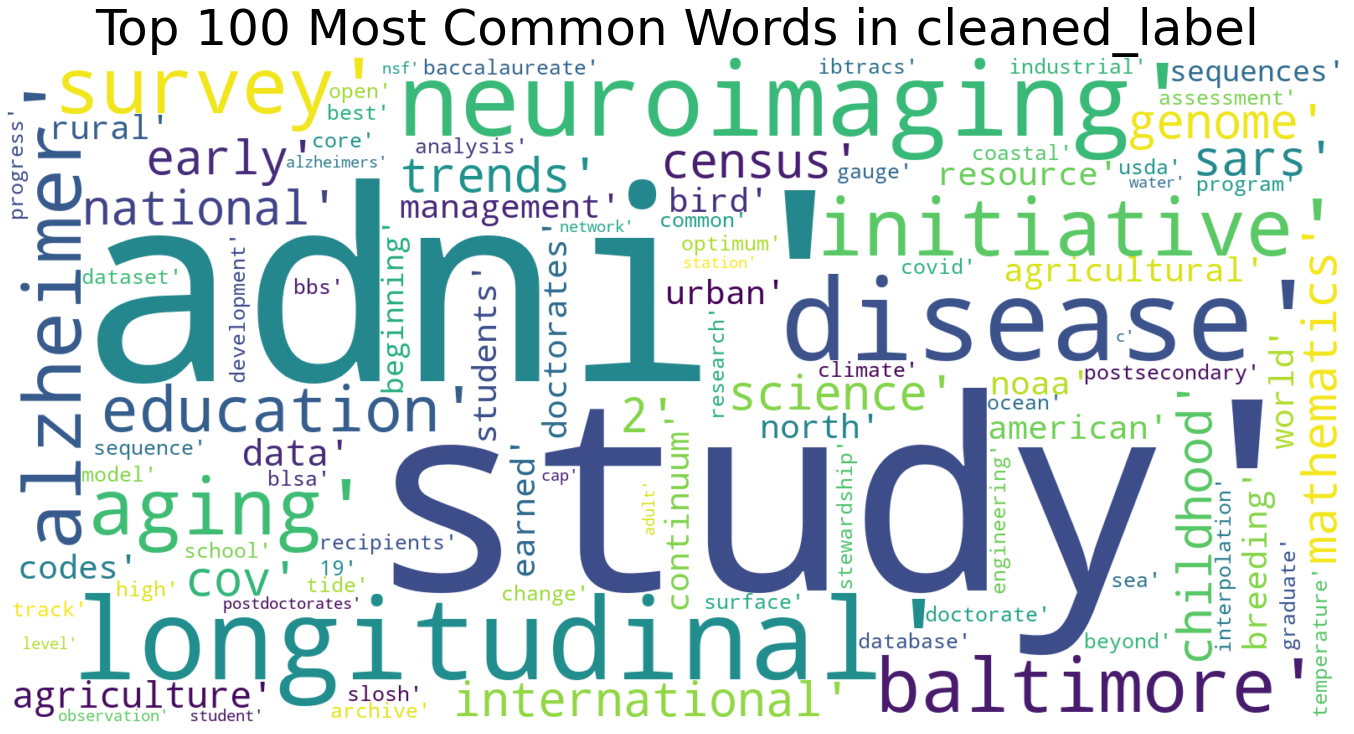

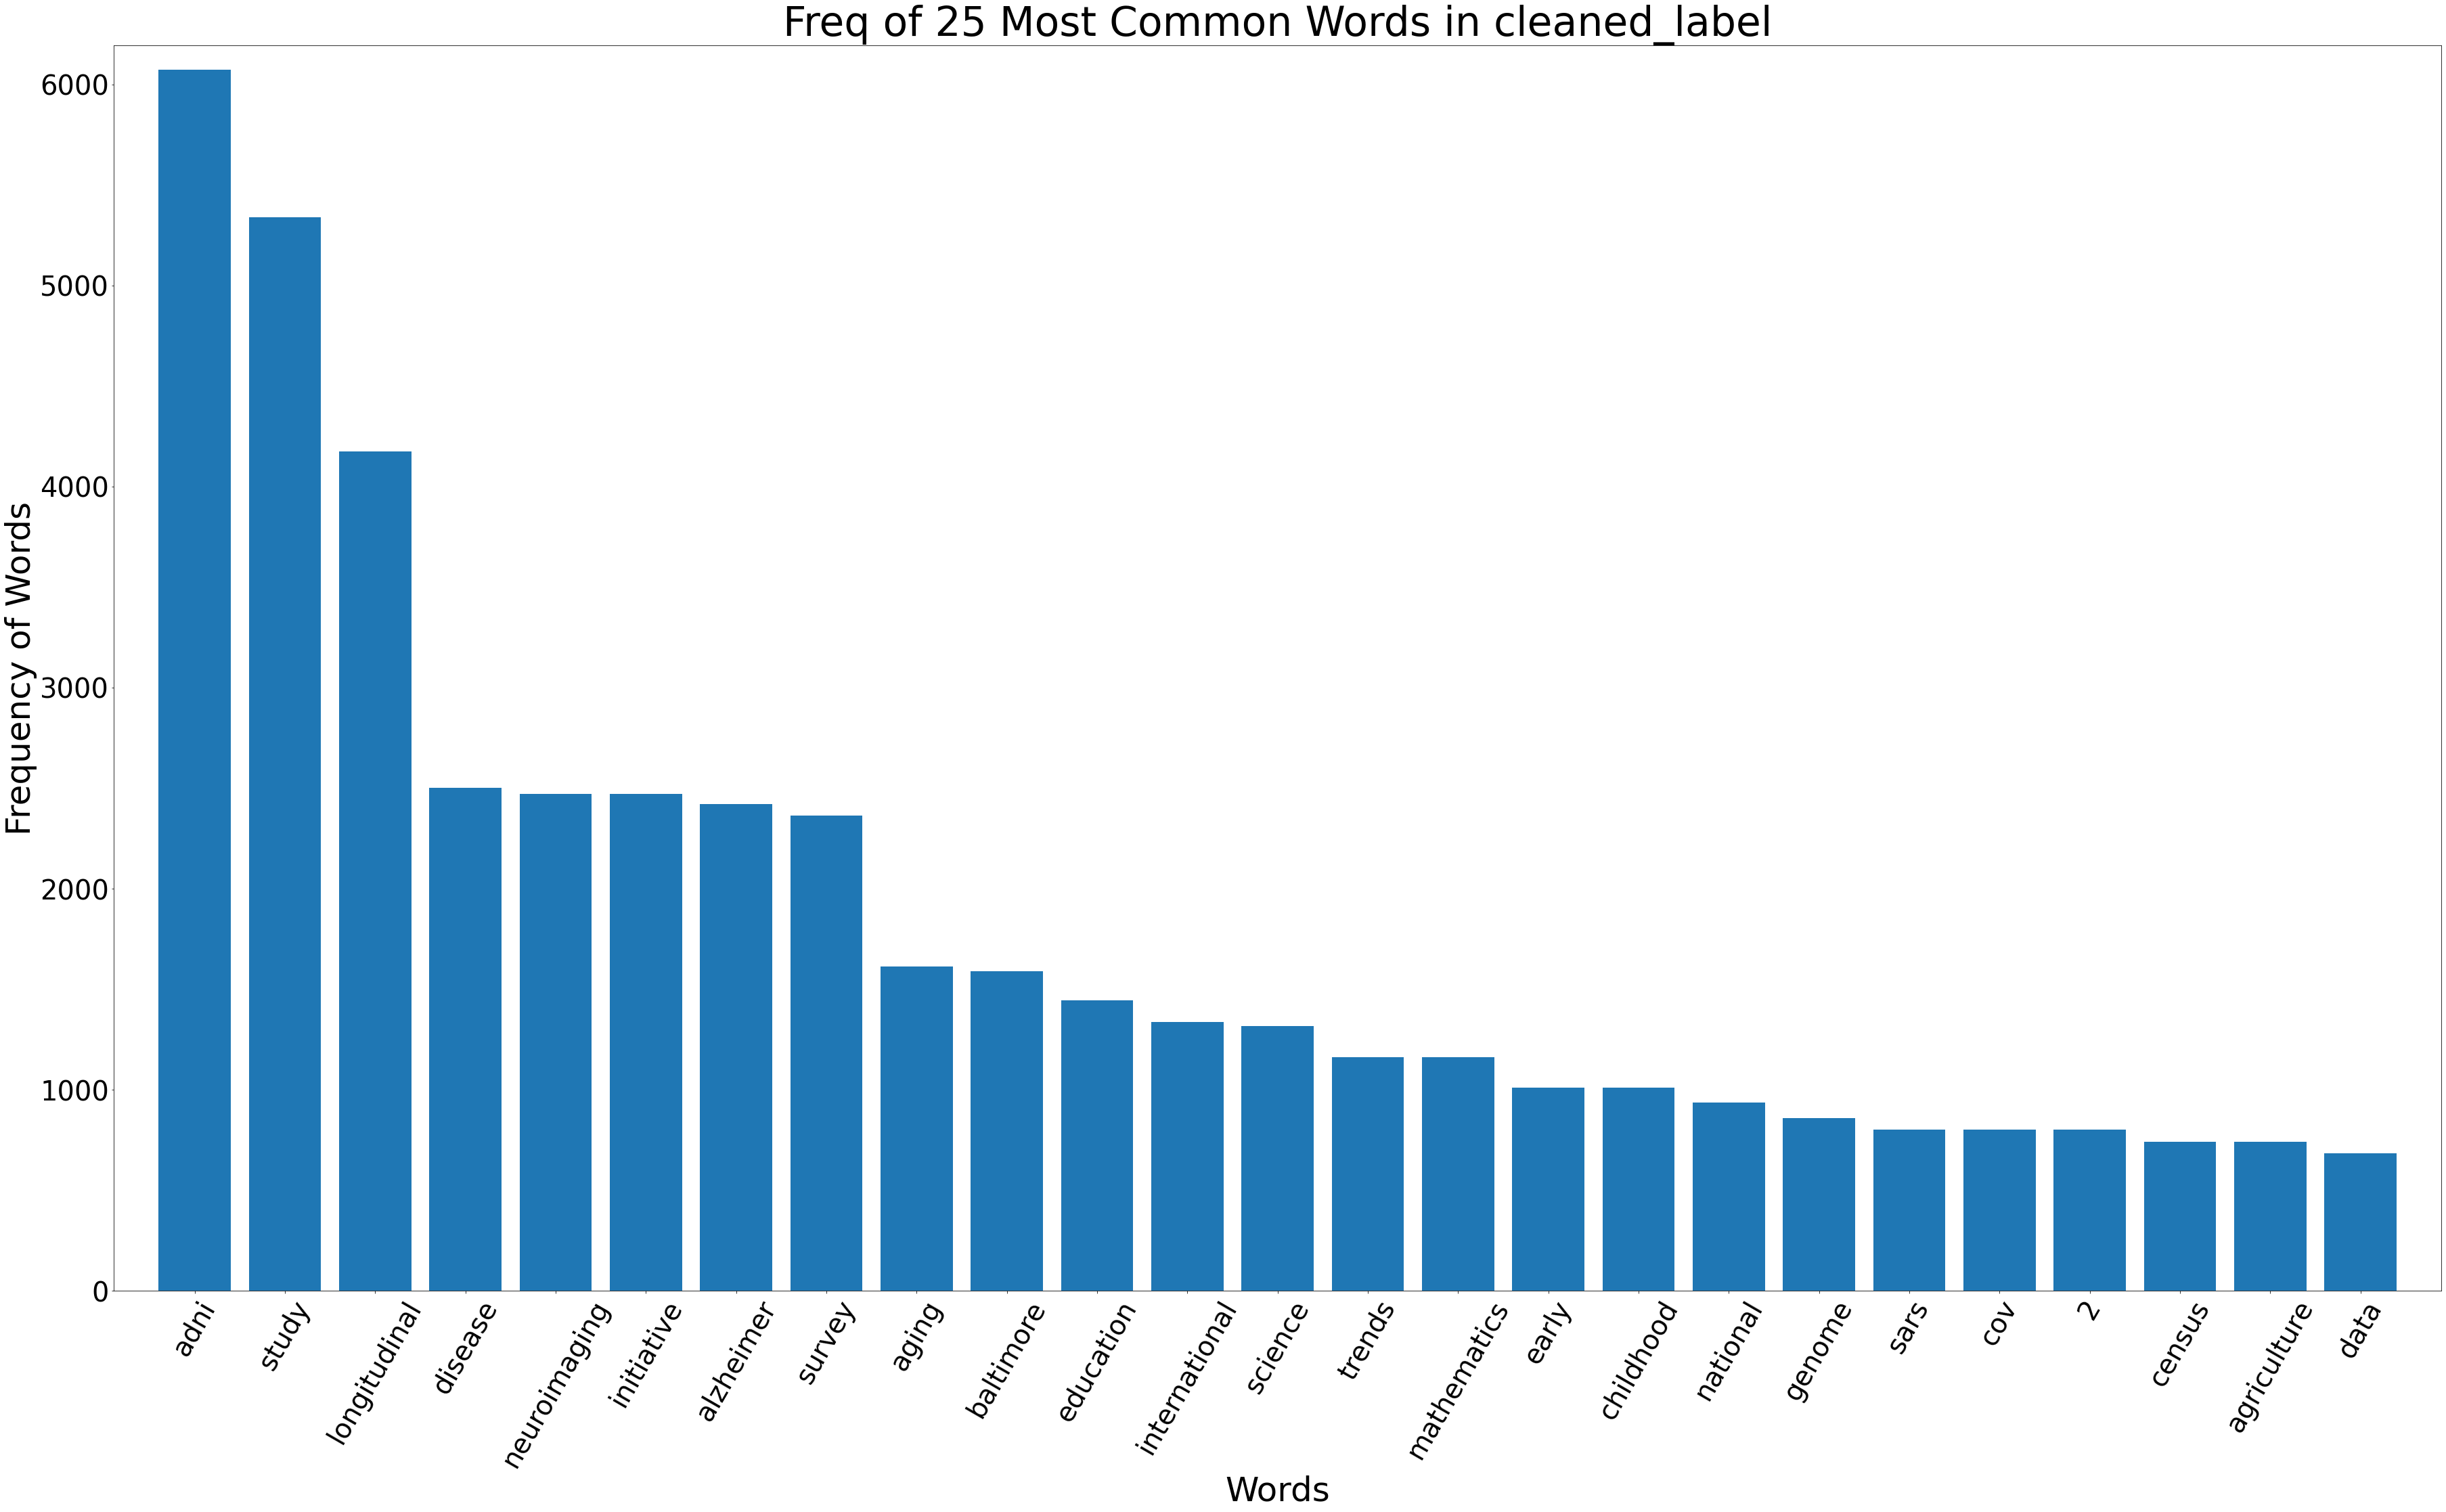

In [16]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=STOPWORDS).generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in cleaned_label', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in cleaned_label', fontsize=60)
plt.show()

In [17]:
def prepare_text(text, nlp=nlp):
    '''
    Returns the text after stop-word removal and lemmatization.
    text - Sentence to be processed
    nlp - Spacy NLP model
    '''
    doc = nlp(text)
    lemma_list = [token.lemma_ for token in doc if not token.is_stop]
    lemmatized_sentence = ' '.join(lemma_list)
    
    return lemmatized_sentence

In [18]:
#replaced for text_cleaning()

def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

In [19]:
# %%time
# tqdm.pandas()
# train_df['text'] = train_df['text'].progress_apply(prepare_text)

<a id='5'></a>
# 5. Baseline model and Submission

The baseline model starts with matching the dataset names with the text of the test set to see which known datsets occur for each text. 

In [20]:
# temp_1 = [x.lower() for x in train_df['dataset_label'].unique()]
# temp_2 = [x.lower() for x in train_df['dataset_title'].unique()]
# temp_3 = [x.lower() for x in train_df['cleaned_label'].unique()]

# existing_labels = set(temp_1 + temp_2 + temp_3)
# id_list = []
# lables_list = []
# for index, row in tqdm(sample_sub.iterrows()):
#     sample_text = row['cleaned_text']
#     row_id = row['Id']
#     temp_df = train_df[train_df['cleaned_text'] == text_cleaning(sample_text)]
#     cleaned_labels = temp_df['cleaned_label'].to_list()
#     for known_label in existing_labels:
#         if known_label in sample_text.lower():
#             cleaned_labels.append(clean_text(known_label))
#     cleaned_labels = [clean_text(x) for x in cleaned_labels]
#     cleaned_labels = set(cleaned_labels)
#     lables_list.append('|'.join(cleaned_labels))
#     id_list.append(row_id)

In [21]:
# submission = pd.DataFrame()
# submission['Id'] = id_list
# submission['PredictionString'] = lables_list

In [22]:
# # pd.set_option("display.max_rows", None, "display.max_columns", None)
# submission.head()

In [23]:
# submission.to_csv('submission.csv', index=False)

<a id='6'></a>
# 6. Sentence Classifier dataset creation


Create sentence dataset based on dataset occurences per sentence. 

SENTENCE_DATASET = id | sentence | label | mentioned_dataset

In [24]:
# %%time
# from IPython.display import clear_output

# #sensitivity influences the amount a ds name needs to match in order to label the sentence with a ds occurence
# sensitivity = 90

# sentence_dataset = pd.DataFrame()

# i = 0
# sentences = []

# len_unique = len(train_df['Id'].unique())

# for ds_id in train_df['Id'].unique():
#     print(f"{i/len_unique*100}%")
#     i +=1
#     clear_output(wait=True)
#     #Get all datasets present in text
#     temp_1 = [x.lower() for x in train_df[train_df['Id'] == ds_id]['dataset_label'].unique()]
#     temp_2 = [x.lower() for x in train_df[train_df['Id'] == ds_id]['dataset_title'].unique()]
#     temp_3 = [x.lower() for x in train_df[train_df['Id'] == ds_id]['cleaned_label'].unique()]
    
#     temp_ds = temp_1 + temp_2 + temp_3
# #     temp_ds = list(train_df.loc[train_df['Id'] == ds_id]['cleaned_label'])
# #     text = list(train_df.loc[(train_df['Id'] == ds_id) & (train_df['cleaned_label'] == temp_ds[0])]['text'])[0]
#     text = list(train_df.loc[(train_df['Id'] == ds_id)]['text'])
#     for sentence in nltk.tokenize.sent_tokenize(str(text)):
#         sentence = text_cleaning(sentence)
        
#         ds_present = 0
#         ds_sentence = ""
        
#         ds_sentence = []
#         for ds in temp_ds:
            
# #             if fuzz.partial_ratio(sentence, ds) > sensitivity:
#             if ds in sentence:
#                 ds_present = 1
#                 ds_sentence.append(ds)
        
#         ds_sentence = '|'.join(ds_sentence)
#         sentences.append({'Id':ds_id, 'sentence':sentence, 'label':ds_present, 'dataset_name':ds_sentence})
        
            


In [25]:
# sent_df = pd.DataFrame(sentences)
# sent_df.to_csv('sent_df2.csv', index=False)
# sent_df.head()

In [26]:
# print(f"sentences with dataset: {len(sent_df[sent_df['label'] == 1])} \ntotal sentences: {len(sent_df)}")

<a id='7'></a>
# 7. Naive Bayes classifier

In [27]:
neg_multiple = 9

df = sent_df[sent_df['label'] == 1]  # positive examples
df = df.append(sent_df[sent_df['label'] == 0].sample(df.shape[0] * neg_multiple))
df['clean'] = df.sentence.str.lower().replace(r"[^a-z ]+","", regex=True)
df.head()

,Id,sentence,label,dataset_name,clean
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,this study used data from the national educati...,1,national education longitudinal study|educatio...,this study used data from the national educati...
28,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,any college degree attainment the study author...,1,national education longitudinal study|educatio...,any college degree attainment the study author...
30,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,the study author collected information on bach...,1,national education longitudinal study|educatio...,the study author collected information on bach...
60,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,this study used data from the national educati...,1,national education longitudinal study|educatio...,this study used data from the national educati...
88,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,any college degree attainment the study author...,1,national education longitudinal study|educatio...,any college degree attainment the study author...


In [28]:
id_train, id_val = train_test_split(df.Id.unique(), test_size=0.1, random_state=42)
train_idx = df.reset_index()[df.Id.isin(id_train).values].index
val_idx = df.reset_index()[df.Id.isin(id_val).values].index

In [29]:
# Tokenize the sentences
%time df['tokenized'] = df.clean.progress_apply(lambda x: [ \
    w for w in nltk.word_tokenize(str(x)[:500]) if w not in stopword_list])

  0%|          | 0/912250 [00:00<?, ?it/s]

CPU times: user 5min 29s, sys: 3.58 s, total: 5min 32s
Wall time: 5min 29s


In [30]:
unique_words = Counter()
for words in tqdm(df.tokenized.values):
    unique_words.update(words)
print (f"Unique words: {len(unique_words)}")    

  0%|          | 0/912250 [00:00<?, ?it/s]

Unique words: 303712


In [31]:
# remove short and infrequent words
min_occurencies = 10
min_word_len = 3
my_vocab = {k:v for k, v in unique_words.items() if v>=min_occurencies and len(k)>= min_word_len}
my_vocab = {k: v for k, v in sorted(my_vocab.items(), key=lambda item: item[1], reverse=True)}
vocab_size = len(my_vocab)
print (f"Words to be used for regression: {vocab_size}") 

Words to be used for regression: 39440


In [32]:
# create data for training and validation
nb_X_train = df.iloc[train_idx].tokenized
nb_X_val = df.iloc[val_idx].tokenized

nb_y_train = df.iloc[train_idx].label
nb_y_val = df.iloc[val_idx].label

# prepare the vectorizer
vectorizer = CountVectorizer(vocabulary = list(my_vocab.keys()))
%time vectorizer = vectorizer.fit(df.tokenized.apply(lambda x: ' '.join(x)).values)

# vectorize
nb_X_train = vectorizer.transform(nb_X_train.apply(lambda x: ' '.join(x)).values)
nb_X_val = vectorizer.transform(nb_X_val.apply(lambda x: ' '.join(x)).values)

print(nb_X_train.shape, nb_X_val.shape, nb_y_train.shape, nb_y_val.shape)
nb_X_train.shape, nb_X_val.shape, nb_y_train.shape, nb_y_val.shape

CPU times: user 20.4 s, sys: 229 ms, total: 20.7 s
Wall time: 20.7 s
(816354, 39440) (95896, 39440) (816354,) (95896,)


((816354, 39440), (95896, 39440), (816354,), (95896,))

Naïve Bayes baseline accuracy score: 0.9419


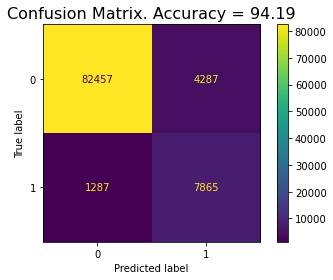

In [33]:
nb_model = MultinomialNB().fit(nb_X_train, nb_y_train)
nb_y_pred = nb_model.predict(nb_X_val)
nb_score = accuracy_score(nb_y_val, nb_y_pred)
print (f"Naïve Bayes baseline accuracy score: {nb_score:.4}")

plot_confusion_matrix (nb_model, nb_X_val, nb_y_val);
plt.title(f"Confusion Matrix. Accuracy = {nb_score*100:.2f}", fontsize=16);

# Fully trained Naive bayes classifier

In [34]:
neg_multiple = 9

df = sent_df[sent_df['label'] == 1]  # positive examples
df = df.append(sent_df[sent_df['label'] == 0].sample(df.shape[0] * neg_multiple))
df['clean'] = df.sentence.str.lower().replace(r"[^a-z ]+","", regex=True)
df.head()

,Id,sentence,label,dataset_name,clean
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,this study used data from the national educati...,1,national education longitudinal study|educatio...,this study used data from the national educati...
28,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,any college degree attainment the study author...,1,national education longitudinal study|educatio...,any college degree attainment the study author...
30,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,the study author collected information on bach...,1,national education longitudinal study|educatio...,the study author collected information on bach...
60,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,this study used data from the national educati...,1,national education longitudinal study|educatio...,this study used data from the national educati...
88,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,any college degree attainment the study author...,1,national education longitudinal study|educatio...,any college degree attainment the study author...


In [35]:
# Tokenize the sentences
%time df['tokenized'] = df.clean.progress_apply(lambda x: [ \
    w for w in nltk.word_tokenize(str(x)[:500]) if w not in stopword_list])

  0%|          | 0/912250 [00:00<?, ?it/s]

CPU times: user 5min 24s, sys: 4.83 s, total: 5min 29s
Wall time: 5min 27s


In [36]:
# df.head()

In [37]:
unique_words = Counter()
for words in tqdm(df.tokenized.values):
    unique_words.update(words)
print (f"Unique words: {len(unique_words)}")    

  0%|          | 0/912250 [00:00<?, ?it/s]

Unique words: 303130


In [38]:
# remove short and infrequent words
min_occurencies = 10
min_word_len = 3
my_vocab = {k:v for k, v in unique_words.items() if v>=min_occurencies and len(k)>= min_word_len}
my_vocab = {k: v for k, v in sorted(my_vocab.items(), key=lambda item: item[1], reverse=True)}
vocab_size = len(my_vocab)
print (f"Words to be used for regression: {vocab_size}") 

Words to be used for regression: 39306


In [39]:
nb_X_train = df.tokenized
nb_y_train = df.label

# prepare the vectorizer
vectorizer = CountVectorizer(vocabulary = list(my_vocab.keys()))
%time vectorizer = vectorizer.fit(df.tokenized.apply(lambda x: ' '.join(x)).values)

nb_X_train = vectorizer.transform(nb_X_train.apply(lambda x: ' '.join(x)).values)

nb_model = MultinomialNB().fit(nb_X_train, nb_y_train)

CPU times: user 20.6 s, sys: 265 ms, total: 20.9 s
Wall time: 20.8 s


In [40]:
# del nb_X_train
# del nb_y_train
# del df

In [41]:
# nb_model = pickle.load(open('../input/nbmodel/nb_model.sav', 'rb'))

In [42]:
# %%time 
# tqdm.pandas()
# sample_sub['text'] = sample_sub['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))
# # sample_sub['text'] = sample_sub['text'].progress_apply(text_cleaning)
# sample_sub.head()

In [43]:
# test_sentence_datset = pd.DataFrame()
# test_sentences = []

# for ds_id in sample_sub['Id']:
    
#     text = list(sample_sub.loc[(sample_sub['Id'] == ds_id)]['text'])[0]
    
#     for sentence in nltk.tokenize.sent_tokenize(text):
#         sentence = text_cleaning(sentence)
        
#         test_sentences.append({'Id':ds_id, 'sentence':sentence})

In [44]:
# test_sent_df = pd.DataFrame(test_sentences)
# test_sent_df.head()

In [45]:
# # Tokenize the sentences
# %time test_sent_df['tokenized'] = test_sent_df.sentence.progress_apply(lambda x: [ \
#     w for w in nltk.word_tokenize(str(x)[:500]) if w not in stopword_list])

# test_sent_df.head()

In [46]:
# # vectorize
# vectorized_test = vectorizer.transform(test_sent_df['tokenized'].apply(lambda x: ' '.join(x)).values)

# # predict
# test_predict = nb_model.predict(vectorized_test)



In [47]:
# test_sent_df['pred'] = test_predict
# test_sent_df.head()

In [48]:
# nb_model.predict(vectorizer.transform(nltk.word_tokenize("test"))) == 0

In [49]:
# test_rows = [] # test data in NER format
# paper_length = [] # store the number of sentences each paper has

# for paper_id in sample_sub['Id']:
#     nr_sentences = 0
#     for sentence in test_sent_df[(test_sent_df['pred'] == 1) & (test_sent_df['Id'] == paper_id)]['tokenized']: 
# #     for sentence in test_sent_df[(test_sent_df['Id'] == paper_id)]['tokenized']:
#         dummy_tags = ['O']*len(sentence)
#         test_rows.append({'tokens' : sentence, 'tags' : dummy_tags})
#         nr_sentences += 1
#     paper_length.append(nr_sentences)

In [50]:
# print(len(test_rows))

In [51]:
# paper_length

In [52]:
# old code


# temp_1 = [x.lower() for x in train_df['dataset_label'].unique()]
# temp_2 = [x.lower() for x in train_df['dataset_title'].unique()]
# temp_3 = [x.lower() for x in train_df['cleaned_label'].unique()]

# existing_labels = set(temp_1 + temp_2 + temp_3)
# id_list = []
# lables_list = []
# prev_id = []
# cleaned_labels = []
# for index, row in tqdm(test_sent_df.iterrows()):
    
#     if prev_id == []:
#         prev_id = row["Id"]
    
#     if row['Id'] != prev_id or index == len(test_sent_df)-1:
#         cleaned_labels = [clean_text(x) for x in cleaned_labels]
#         cleaned_labels = set(cleaned_labels)
#         lables_list.append('|'.join(cleaned_labels))
#         id_list.append(prev_id)
#         cleaned_labels = []
#         prev_id = row['Id']
    
#     if row['pred'] == 1:
#         for known_label in existing_labels:
# #             if fuzz.partial_ratio(known_label, row['sentence'].lower()) > 90 and clean_text(known_label) not in cleaned_labels:
#              if known_label in row['sentence'].lower() and clean_text(known_label) not in cleaned_labels:
#                 cleaned_labels.append(clean_text(known_label))

In [53]:
# submission = pd.DataFrame()
# submission['Id'] = id_list
# submission['PredictionString'] = lables_list

In [54]:
# submission.to_csv('submission.csv', index=False)
# submission.head()

<a id='8'></a>
# 8. Named Entity Recognition

### Experimentation

In [55]:
MAX_SAMPLE = None # set a small number for experimentation, set None for production.

In [56]:
!pip install datasets --no-index --find-links=file:///kaggle/input/coleridge-packages/packages/datasets
!pip install ../input/coleridge-packages/seqeval-1.2.2-py3-none-any.whl
!pip install ../input/coleridge-packages/tokenizers-0.10.1-cp37-cp37m-manylinux1_x86_64.whl
!pip install ../input/coleridge-packages/transformers-4.5.0.dev0-py3-none-any.whl

Looking in links: file:///kaggle/input/coleridge-packages/packages/datasets
Processing /kaggle/input/coleridge-packages/packages/datasets/datasets-1.5.0-py3-none-any.whl
Processing /kaggle/input/coleridge-packages/packages/datasets/huggingface_hub-0.0.7-py3-none-any.whl
Processing /kaggle/input/coleridge-packages/packages/datasets/xxhash-2.0.0-cp37-cp37m-manylinux2010_x86_64.whl
Processing /kaggle/input/coleridge-packages/packages/datasets/tqdm-4.49.0-py2.py3-none-any.whl
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.55.1
    Uninstalling tqdm-4.55.1:
      Successfully uninstalled tqdm-4.55.1
Processing /kaggle/input/coleridge-packages/seqeval-1.2.2-py3-none-any.whl
Processing /kaggle/input/coleridge-packages/tokenizers-0.10.1-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.4
    Uninstalling tokenizers-0.9.4:
      Successfully uninstalled tokenizers-0.9.4
ERROR: pip's dependency resolver does 

In [57]:
import os
import re
import json
import time
import datetime
import random
import glob
import importlib

import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(123)
np.random.seed(456)

In [58]:
train_path = '../input/coleridgeinitiative-show-us-the-data/train.csv'
train = pd.read_csv(train_path)
train = train[:MAX_SAMPLE]

paper_train_folder = '../input/coleridgeinitiative-show-us-the-data/train'
papers = {}
for paper_id in train['Id'].unique():
    with open(f'{paper_train_folder}/{paper_id}.json', 'r') as f:
        paper = json.load(f)
        papers[paper_id] = paper

In [59]:
sample_submission_path = '../input/coleridgeinitiative-show-us-the-data/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

paper_test_folder = '../input/coleridgeinitiative-show-us-the-data/test'
for paper_id in sample_submission['Id']:
    with open(f'{paper_test_folder}/{paper_id}.json', 'r') as f:
        paper = json.load(f)
        papers[paper_id] = paper

In [60]:
all_labels = set()

for label_1, label_2, label_3 in train[['dataset_title', 'dataset_label', 'cleaned_label']].itertuples(index=False):
    all_labels.add(str(label_1).lower())
    all_labels.add(str(label_2).lower())
    all_labels.add(str(label_3).lower())

#add additional labels    
for l in adnl_govt_labels.title:
    all_labels.add(l)

all_labels = set(all_labels)
print(f'No. different labels: {len(all_labels)}')

No. different labels: 2159


In [61]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

def totally_clean_text(txt):
    txt = clean_text(txt)
    txt = re.sub(' +', ' ', txt)
    return txt

In [62]:
literal_preds = []

for paper_id in sample_submission['Id']:
    paper = papers[paper_id]
    text_1 = '. '.join(section['text'] for section in paper).lower()
    text_2 = totally_clean_text(text_1)
    
    labels = set()
    for label in all_labels:
        if label in text_1 or label in text_2:
            labels.add(clean_text(label))
    
    literal_preds.append('|'.join(labels))

In [63]:
literal_preds[:5]

['adni|pubmed|alzheimer s disease neuroimaging initiative adni',
 'trends in international mathematics and science study|integrated postsecondary education data system|ipeds|nces common core of data|common core of data|progress in international reading literacy study|schools and staffing survey',
 'sea lake and overland surges from hurricanes|slosh model|noaa storm surge inundation',
 'rural urban continuum codes']

In [64]:
MAX_LENGTH = 64 # max no. words for each sentence.
OVERLAP = 20 # if a sentence exceeds MAX_LENGTH, we split it to multiple sentences with overlapping

PREDICT_BATCH = 64000 

PRETRAINED_PATH = '../input/coleridge-bert-models/output'
TEST_INPUT_SAVE_PATH = './input_data'
TEST_NER_DATA_FILE = 'test_ner_input.json'
TRAIN_PATH = '../input/coleridge-bert-models/train_ner.json'
VAL_PATH = '../input/coleridge-bert-models/train_ner.json'

PREDICTION_SAVE_PATH = './pred'
PREDICTION_FILE = 'test_predictions.txt'

In [65]:
train = train.groupby('Id').agg({
    'pub_title': 'first',
    'dataset_title': '|'.join,
    'dataset_label': '|'.join,
    'cleaned_label': '|'.join
}).reset_index()

print(f'No. grouped training rows: {len(train)}')

No. grouped training rows: 14316


In [66]:
def clean_training_text(txt):
    """
    similar to the default clean_text function but without lowercasing.
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt)).strip()

def shorten_sentences(sentences):
    short_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) > MAX_LENGTH:
            for p in range(0, len(words), MAX_LENGTH - OVERLAP):
                short_sentences.append(' '.join(words[p:p+MAX_LENGTH]))
        else:
            short_sentences.append(sentence)
    return short_sentences

In [67]:
test_rows = [] # test data in NER format
paper_length = [] # store the number of sentences each paper has

for paper_id in sample_submission['Id']:
    # load paper
    paper = papers[paper_id]
    
    # extract sentences
    sentences = [clean_training_text(sentence) for section in paper 
                 for sentence in section['text'].split('.')
                ]
    sentences = shorten_sentences(sentences) # make sentences short

#     sentences = [sentence for sentence in sentences if nb_model.predict(vectorizer.transform(nltk.word_tokenize(sentence))) == 1]
    sentences = [sentence for sentence in sentences if len(sentence) > 10] # only accept sentences with length > 10 chars
    sentences = [sentence for sentence in sentences if any(word in sentence.lower() for word in ['data', 'study'])]
    
    
    sentences2 = []
    for sentence in sentences:
        df = pd.DataFrame()
        df['sent'] = [nltk.word_tokenize(sentence)]
#         print(df['sent'])
#         print(nb_model.predict(vectorizer.transform(df['sent'].apply(lambda x: ' '.join(x)).values)))
        if nb_model.predict(vectorizer.transform(df['sent'].apply(lambda x: ' '.join(x)).values)) == 1:
            sentences2.append(sentence)
    
    sentences = sentences2
    
    # collect all sentences in json
    for sentence in sentences:
        sentence_words = sentence.split()
        dummy_tags = ['O']*len(sentence_words)
        test_rows.append({'tokens' : sentence_words, 'tags' : dummy_tags})
    
    # track which sentence belongs to which data point
    paper_length.append(len(sentences))
    
print(f'total number of sentences: {len(test_rows)}')

total number of sentences: 54


In [68]:
os.environ["MODEL_PATH"] = f"{PRETRAINED_PATH}"
os.environ["TRAIN_FILE"] = f"{TRAIN_PATH}"
os.environ["VALIDATION_FILE"] = f"{VAL_PATH}"
os.environ["TEST_FILE"] = f"{TEST_INPUT_SAVE_PATH}/{TEST_NER_DATA_FILE}"
os.environ["OUTPUT_DIR"] = f"{PREDICTION_SAVE_PATH}"

In [69]:
# copy my_seqeval.py to the working directory because the input directory is non-writable
!cp /kaggle/input/coleridge-packages/my_seqeval.py ./

# make necessart directories and files
os.makedirs(TEST_INPUT_SAVE_PATH, exist_ok=True)

In [70]:
def bert_predict():
    !python ../input/kaggle-ner-utils/kaggle_run_ner.py \
    --model_name_or_path "$MODEL_PATH" \
    --train_file "$TRAIN_FILE" \
    --validation_file "$VALIDATION_FILE" \
    --test_file "$TEST_FILE" \
    --output_dir "$OUTPUT_DIR" \
    --report_to 'none' \
    --seed 123 \
    --do_predict

In [71]:
bert_outputs = []

for batch_begin in range(0, len(test_rows), PREDICT_BATCH):
    # write data rows to input file
    with open(f'{TEST_INPUT_SAVE_PATH}/{TEST_NER_DATA_FILE}', 'w') as f:
        for row in test_rows[batch_begin:batch_begin+PREDICT_BATCH]:
            json.dump(row, f)
            f.write('\n')
    
    # remove output dir
    !rm -r "$OUTPUT_DIR"
    
    # do predict
    bert_predict()
    
    # read predictions
    with open(f'{PREDICTION_SAVE_PATH}/{PREDICTION_FILE}') as f:
        this_preds = f.read().split('\n')[:-1]
        bert_outputs += [pred.split() for pred in this_preds]

rm: cannot remove './pred': No such file or directory
Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-4360ab76c83ec0e2/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
[INFO|configuration_utils.py:470] 2021-06-14 08:09:32,228 >> loading configuration file ../input/coleridge-bert-models/output/config.json
[INFO|configuration_utils.py:508] 2021-06-14 08:09:32,229 >> Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "ner",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps":

In [72]:
# get test sentences
test_sentences = [row['tokens'] for row in test_rows]

del test_rows

In [73]:
bert_dataset_labels = [] # store all dataset labels for each publication

for length in paper_length:
    labels = set()
    for sentence, pred in zip(test_sentences[:length], bert_outputs[:length]):
        curr_phrase = ''
        for word, tag in zip(sentence, pred):
            if tag == 'B': # start a new phrase
                if curr_phrase:
                    labels.add(curr_phrase)
                    curr_phrase = ''
                curr_phrase = word
            elif tag == 'I' and curr_phrase: # continue the phrase
                curr_phrase += ' ' + word
            else: # end last phrase (if any)
                if curr_phrase:
                    labels.add(curr_phrase)
                    curr_phrase = ''
        # check if the label is the suffix of the sentence
        if curr_phrase:
            labels.add(curr_phrase)
            curr_phrase = ''
    
    # record dataset labels for this publication
    bert_dataset_labels.append(labels)
    
    del test_sentences[:length], bert_outputs[:length]

In [74]:
bert_dataset_labels[:5]

[{'Alzheimer s Disease Neuroimaging Initiative ADNI'},
 {'Trends in International Mathematics and Science Study'},
 set(),
 set()]

In [75]:
def jaccard_similarity(s1, s2):
    l1 = s1.split(" ")
    l2 = s2.split(" ")    
    intersection = len(list(set(l1).intersection(l2)))
    union = (len(l1) + len(l2)) - intersection
    return float(intersection) / union

filtered_bert_labels = []

for labels in bert_dataset_labels:
    filtered = []
    
    for label in sorted(labels, key=len):
        label = clean_text(label)
        if len(filtered) == 0 or all(jaccard_similarity(label, got_label) < 0.75 for got_label in filtered):
            filtered.append(label)
    
    filtered_bert_labels.append('|'.join(filtered))

In [76]:
filtered_bert_labels[:5]

['alzheimer s disease neuroimaging initiative adni',
 'trends in international mathematics and science study',
 '',
 '']

In [77]:
final_predictions = []
for literal_match, bert_pred in zip(literal_preds, filtered_bert_labels):
    if literal_match:
        final_predictions.append(literal_match)
    else:
        final_predictions.append(bert_pred)

In [78]:
# final_predictions = filtered_bert_labels

In [79]:
sample_submission['PredictionString'] = final_predictions
sample_submission.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,adni|pubmed|alzheimer s disease neuroimaging i...
1,2f392438-e215-4169-bebf-21ac4ff253e1,trends in international mathematics and scienc...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,sea lake and overland surges from hurricanes|s...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


In [80]:
sample_submission.to_csv(f'submission.csv', index=False)